# COMP41680 - Ryan Jennings 19205824

This project takes a name of an Actor e.g. __Nicolas Cage__ or __Halle Berry__, and gathers the information for all their acting credits from **IMDB** before plotting the information and making predictions about their upcoming movies.

In [113]:
import csv
import json
import re

from typing import Any, Dict, List, Union

import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from PIL import Image
from sklearn.linear_model import LinearRegression

JsonType = Dict[str, Any]

<span style='color: red'>**API Chosen:**</span>

For this project I made use of 2 APIs and scraping 1 webpage.  
The first API I used was the IMDB suggestions API which seems to be the only publically available API they provide now which made this project a little difficult.  
The endpoint for this API was `https://sg.media-imdb.com/suggests/{first letter}/{search}.json`. It simply returns the search suggestions as you would get if you went to their home page and searched for an actor or show. See the example for searching __Nicolas Cage__ here: `https://sg.media-imdb.com/suggests/n/nicolas%20cage.json`.  

I used the suggestions API to get their IMDB actor Id. I used that Id find their unique webpage on IMDB. Then since IMDB didn't provide an API I had to scrape their webpage to find all the tv show and movie Ids that the actor has starred in (sorry IMDB system engineers I limited my time spent scraping as much as possible).  

When I had a list of all the IMDB tv show and movie Ids for a given actor I could make use of the main API.
The main API was `OMDB` which provides an API to the IMDB database for movies and tv shows based on a movie/tv Id. Their website with documentation and examples can be found here: `http://www.omdbapi.com/`.  I used this API to get as much information as possible about a movie/tv show to be used for later analysis.

In [3]:
OMDB_API_KEY: str = '7bab4d15'

In [4]:
ACTOR_NAME: str = 'Nicolas Cage'

In [7]:
def get_actor_imdb_info(name: str) -> JsonType:
    """
    For a given actor name return their IMDB data consisting of Name, Id and Image URL

    Keyword arguments:
    name: str - Name of actor that will be searched for on IMBD.com
    
    Returns: Jsontype - json data from imdb search
    """
    search_name: str = ''.join(name.split(' ')).lower()
    imdb_suggestions_url: str = f"https://sg.media-imdb.com/suggests/{name[0].lower()}/{search_name}.json"
    res = requests.get(imdb_suggestions_url)
    valid_json_str: str = res.text[(5 + len(name)):-1]
    json_data: JsonType = json.loads(valid_json_str)['d'][0]
    return json_data

def get_actors_credits_by_imdb_id(act_id: str) -> List[str]:
    """
    Returns a list of Ids of the Actors acting credits from IMDB

    Keyword arguments:
    act_id: str - Actor's IMDB Id

    Returns: List[str] - List of IMDB Ids of Actor's acting credits
    """
    film_ids: List[str] = []
    actor_url: str = f"https://www.imdb.com/name/{act_id}"
    actor_page = requests.get(actor_url)
    html_soup: BeautifulSoup = BeautifulSoup(actor_page.text, 'html.parser')
    films = html_soup.find_all('div', class_='filmo-category-section')
    links = films[0].find_all('a')
    for link in links:
        if link.has_attr('href') and link.attrs['href'].startswith('/title'):
            film_ids.append(link.attrs['href'].split('/')[2])
    return film_ids

def get_actor_image(actor_data: JsonType) -> Image:
    """
    Retrieve an image object of an Actor from IMDB

    Keyword arguments:
    actor_data: JsonType - Actor json data from IMDB suggestion

    Return: PIL.Image.Image - Python Imaging Library Image object for Actor
    """
    actor_img_url: str = actor_data['i'][0]
    im = Image.open(requests.get(actor_img_url, stream=True).raw)
    return im.resize((actor_data['i'][1]//5, actor_data['i'][2]//5), Image.ANTIALIAS)

In [9]:
actor_data: str = get_actor_imdb_info(ACTOR_NAME)
credit_ids: List[str] = get_actors_credits_by_imdb_id(actor_data['id'])
actor_image: Image = get_actor_image(actor_data=actor_data)

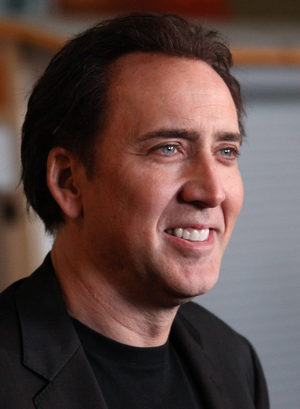

In [10]:
actor_image

The free version of the OMDB Api has a limit of **1000 calls a day**. Even the most prolific of famous actors such as Nicolas Cage (103), Michael Madsen (307), Better Midler (114), etc. don't come close to the 1000 a day limit.  
Although if anybody is interesting in viewing data about Mel Blanc (1149) or Mark Wood (1748) or other power-actors then functionality is provided to continue on over multiple days to build up the dataset.

In [11]:
def retrieve_credit_data_by_id(show_id: str) -> JsonType:
    """
    Movie data by imdb id
    """
    omdb_url: str = f"http://www.omdbapi.com/?apikey={OMDB_API_KEY}&i={show_id}"
    return requests.get(omdb_url).json()

In [13]:
credits: JsonType = []
for m_id in credit_ids:
    res = retrieve_credit_data_by_id(m_id)
    if res.get('Title', False):
        credits.append(res)

Example of a single credit and how it looks

In [14]:
credits[-1]

{'Title': 'Best of Times',
 'Year': '1981',
 'Rated': 'N/A',
 'Released': 'N/A',
 'Runtime': '95 min',
 'Genre': 'Comedy',
 'Director': 'Don Mischer',
 'Writer': 'Bob Arnott, Carol Hatfield, Lane Sarasohn',
 'Actors': 'Crispin Glover, Jill Schoelen, Nicolas Cage, Julie Piekarski',
 'Plot': "Here's the lives of 7 teenage friends in 1981, singing, dancing and breaking the 4th wall.",
 'Language': 'English',
 'Country': 'USA',
 'Awards': 'N/A',
 'Poster': 'https://m.media-amazon.com/images/M/MV5BNjZlYTFiMzgtZWYwMS00OTExLWI3YmQtYTc5YzlmYzJiMTI0XkEyXkFqcGdeQXVyMzU0NzkwMDg@._V1_SX300.jpg',
 'Ratings': [{'Source': 'Internet Movie Database', 'Value': '5.5/10'}],
 'Metascore': 'N/A',
 'imdbRating': '5.5',
 'imdbVotes': '197',
 'imdbID': 'tt0082064',
 'Type': 'movie',
 'DVD': 'N/A',
 'BoxOffice': 'N/A',
 'Production': 'N/A',
 'Website': 'N/A',
 'Response': 'True'}

In [15]:
def write_credits_data_to_csv(credits: JsonType) -> None:
    """
    Convert movie data from json to csv and write to file
    """
    with open('credits_data.csv', 'w') as credits_file:
        csv_writer = csv.DictWriter(credits_file, fieldnames=list(credits[0].keys()), delimiter=',')
        # Need to separate ratings to different headers
        csv_writer.writeheader()
        for credit in credits:
            csv_writer.writerow(credit)

In [16]:
write_credits_data_to_csv(credits=credits)

In [38]:
# Read csv file into pandas dataframe
credits = pd.read_csv('credits_data.csv')

In [18]:
num_instances, num_attributes = credits.shape
print(f"Number of instances: {num_instances}\nNumber of attributes: {num_attributes}")

Number of instances: 102
Number of attributes: 25


In [19]:
credits.head()

,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Actors,Plot,...,Metascore,imdbRating,imdbVotes,imdbID,Type,DVD,BoxOffice,Production,Website,Response
0,10 Double Zero,2017,NaN,NaN,NaN,Crime,Christian Sesma,"Christian Sesma, Paul Sloan, Nick Vallelonga",NaN,DET. DANA REEVES is infamous for crossing the ...,...,NaN,NaN,NaN,tt5843576,movie,NaN,NaN,NaN,NaN,True
1,The Croods 2,2020,NaN,23 Dec 2020,NaN,"Animation, Adventure, Comedy, Family, Fantasy",Joel Crawford,"Kirk DeMicco (creator), Dan Hageman (screenpla...","Nicolas Cage, Ryan Reynolds, Emma Stone, Kat D...",The prehistoric family the Croods are challeng...,...,NaN,NaN,NaN,tt2850386,movie,NaN,NaN,20th Century Fox,NaN,True
2,Pig,2020,NaN,NaN,NaN,Drama,Michael Sarnoski,"Vanessa Block, Michael Sarnoski, Michael Sarnoski","Nicolas Cage, Alex Wolff, Adam Arkin, Nina Bel...",A truffle hunter who lives alone in the Oregon...,...,NaN,NaN,NaN,tt11003218,movie,NaN,NaN,NaN,NaN,True
3,Prisoners of the Ghostland,2020,NaN,NaN,NaN,"Action, Horror, Thriller",Sion Sono,"Aaron Hendry, Reza Sixo Safai (screenplay)","Nicolas Cage, Sofia Boutella, Ed Skrein, Teres...",A notorious criminal must break an evil curse ...,...,NaN,NaN,NaN,tt6372694,movie,NaN,NaN,NaN,NaN,True
4,Jiu Jitsu,2020,NaN,09 Jul 2020,NaN,"Action, Fantasy",Dimitri Logothetis,"Dimitri Logothetis (Writer), Jim McGrath (Writer)","Nicolas Cage, Marie Avgeropoulos, Frank Grillo...",A new Sci-Fi Martial Arts franchise from Dimit...,...,NaN,NaN,NaN,tt9624766,movie,NaN,NaN,NaN,NaN,True


In [20]:
credits.describe(include='all')

,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Actors,Plot,...,Metascore,imdbRating,imdbVotes,imdbID,Type,DVD,BoxOffice,Production,Website,Response
count,102,102.000000,93,97,97,102,102,101,101,101,...,77.000000,97.000000,97,102,102,85,33,88,0.0,102
unique,102,NaN,6,97,46,66,88,101,101,101,...,NaN,NaN,97,102,1,78,33,54,NaN,1
top,Outcast,NaN,R,22 Dec 2000,96 min,"Action, Crime, Thriller",Paul Schrader,"Andrew Lane, Wayne Crawford","Nicolas Cage, Ryan Reynolds, Emma Stone, Kat D...","1936, Italian army is invading Ethiopia. Lieut...",...,NaN,NaN,"10,327",tt3733778,movie,01 Jun 2004,"$16,816",Sony Pictures Home Entertainment,NaN,True
freq,1,NaN,52,1,6,7,3,1,1,1,...,NaN,NaN,1,1,102,3,1,6,NaN,102
mean,NaN,2004.990196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,49.883117,5.944330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,11.724980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,18.475428,1.077127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,1981.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.000000,3.100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,1995.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,35.000000,5.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,2007.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.000000,6.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,2016.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,66.000000,6.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
credits.columns

Index(['Title', 'Year', 'Rated', 'Released', 'Runtime', 'Genre', 'Director',
       'Writer', 'Actors', 'Plot', 'Language', 'Country', 'Awards', 'Poster',
       'Ratings', 'Metascore', 'imdbRating', 'imdbVotes', 'imdbID', 'Type',
       'DVD', 'BoxOffice', 'Production', 'Website', 'Response'],
      dtype='object')

In [22]:
# Drop unused columns from the dataframe

In [ ]:
# Drop: Writer, Plot, Language?, Country?, Awards, Poster, Ratings?, imdbID, Type, DVD

In [109]:
credits['BoxOffice'].unique()

array([nan, '$4,526', '$21,562,346', '$10,649,893', '$257,588', '$89,515',
       '$187,165,546', '$289,773', '$51,774,002', '$16,816', '$410,819',
       '$10,706,786', '$24,800,000', '$63,143,812', '$20,000,000',
       '$19,548,064', '$1,616,556', '$119,420,252', '$79,948,113',
       '$15,195,406', '$219,932,519', '$17,993,461', '$24,928,753',
       '$115,802,596', '$70,236,496', '$28,100,000', '$12,469,811',
       '$24,033,036', '$172,975,674', '$36,873,198', '$22,184,735',
       '$40,531,308', '$25,261,240', '$100,978,700'], dtype=object)

Clean up Runtime and imdbVotes columns from strings to floats

In [89]:
credits['Runtime'] = credits['Runtime'].apply(lambda x: float(x.replace(' min', '')) if type(x) == str else x)

In [25]:
credits['imdbVotes'] = credits['imdbVotes'].apply(lambda x: float(x.replace(',', '')) if type(x) != float and ',' in x else float(x))

In [120]:
credits['BoxOffice'].apply(lambda x: re.sub('\$|,', '', x) if type(x) != float else x)

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
      ... 
97     NaN
98     NaN
99     NaN
100    NaN
101    NaN
Name: BoxOffice, Length: 102, dtype: object

In [87]:
# Plot Year by Rating
# Plot Runtime by Rating
# Plot Rated by Rating (boxplot?)
# Plot Rated by Runtime (boxplot?)
# Plot Metascore by imdb Rating * 10 (see how well a straight line they correlate with a line of best fit)
# Plot Year by Boxoffice
# Plot Rating by Boxoffice
# Plot Rating by Production Company

In [26]:
credits['imdbVotes'].describe()

count        97.000000
mean      69495.814433
std       94173.700043
min          20.000000
25%        6217.000000
50%       31559.000000
75%       91935.000000
max      509585.000000
Name: imdbVotes, dtype: float64

In [27]:
credits.corr(method='pearson')

,Year,Runtime,Metascore,imdbRating,imdbVotes,Website,Response
Year,1.000000,-0.055867,-0.386582,-0.317142,0.003595,NaN,NaN
Runtime,-0.055867,1.000000,0.290068,0.386817,0.506032,NaN,NaN
Metascore,-0.386582,0.290068,1.000000,0.755419,0.280595,NaN,NaN
imdbRating,-0.317142,0.386817,0.755419,1.000000,0.535331,NaN,NaN
imdbVotes,0.003595,0.506032,0.280595,0.535331,1.000000,NaN,NaN
Website,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Response,NaN,NaN,NaN,NaN,NaN,NaN,NaN


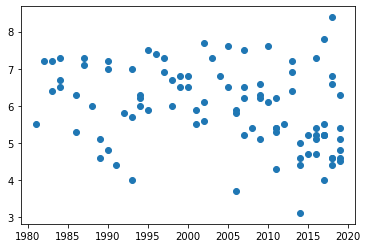

In [90]:
plt.scatter(credits['Year'], credits['imdbRating'])

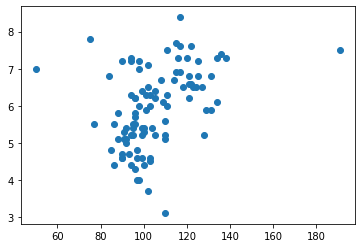

In [91]:
plt.scatter(credits['Runtime'], credits['imdbRating'])

ValueError: zero-size array to reduction operation minimum which has no identity

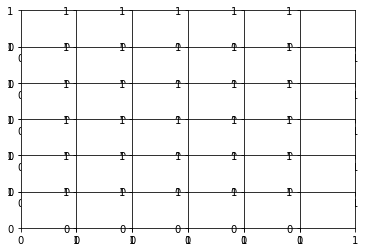

In [93]:
pd.plotting.scatter_matrix(credits)

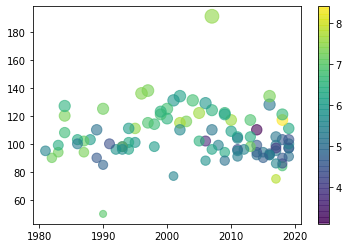

In [30]:
plt.scatter(credits['Year'], credits['Runtime'], s=credits['Runtime'], c=credits['imdbRating'], alpha=0.6, cmap='viridis')
plt.colorbar()

In [86]:
credits[((credits['imdbRating']*10 + credits['Metascore'])/2) > 75]['Title']

11    Spider-Man: Into the Spider-Verse
52                           Grindhouse
61                          Adaptation.
72                             Face/Off
75                    Leaving Las Vegas
91                           Moonstruck
Name: Title, dtype: object

In [32]:
# Apply a Linear Regression onto value to plot the line of best fit
# Try to predict how good his upcoming movies will do based on info about them

In [48]:
ratings = credits.dropna(subset=['imdbRating'], inplace=False)

In [80]:
model = LinearRegression()
years2D = ratings['Year'][:, np.newaxis][::-1]
print(years2D.shape)

(97, 1)


In [81]:
rates = list(ratings['imdbRating'])
model.fit(years2D, rates)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

(0, 10)

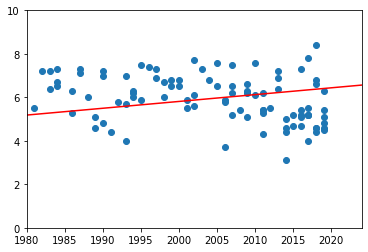

In [82]:
xfit = np.linspace(1980, 2024)
yfit = model.predict(xfit[:, np.newaxis])
plt.scatter(list(ratings['Year']), rates)
plt.plot(xfit, yfit, color='red')
ax = plt.gca()
ax.set_xlim([1980, 2024])
ax.set_ylim([0, 10])

In [47]:
model.intercept_

2024.4460837853348

In [79]:
model.coef_

array([0.03133381])